# FairCause Benchmarking

This is a notebook for benchmarking the performance of the faircause causal estimation using a synthetic SCM. 

In [1]:
import sys
sys.path.insert(0, '/Users/alanma/Documents/CFA_python')


In [2]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
from faircause.faircause import FairCause
from tests.synthetic_data import *
import rpy2.robjects as ro
import rpy2.robjects.pandas2ri as pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr, isinstalled
import rpy2.robjects.packages as rpackages
from rpy2.robjects import r


TV 0.5100000000000001
NDE 0.29999999999999993
NIE -0.06000000000000003
ExpSE_x0 -0.09600000000000003
ExpSE_x1 0.054000000000000034
xde 0.29999999999999993
xie -0.060000000000000026
xse -0.15000000000000016
0.51


In [3]:
# calculate ground truth effects
pux = 0.4
puz = 0.8
puw = 0.2
puy = 0.3
puxz = 0.4

def X(U_x, U_xz): 
    return U_x | U_xz 
def Z(U_xz, U_z): 
    return U_xz + 0.3 *  U_z
def W(X, U_w, Z): 
    return (X + 0.6* U_w ) -  Z
def Y(U_y, X, Z, W): 
    return (U_y * X) + (U_y + 0.3* Z) + (U_y * 0.2* W)




In [4]:
res = compute_true_effects(pux, puz, puw, puy, puxz, X, Z, W, Y)
true_xde = res['xde']
true_xie = res['xie']
true_xse = res['xse']

TV 0.5100000000000001
NDE 0.29999999999999993
NIE -0.06000000000000003
ExpSE_x0 -0.09600000000000003
ExpSE_x1 0.054000000000000034
xde 0.29999999999999993
xie -0.060000000000000026
xse -0.15000000000000016
0.51


In [5]:
# run experiments

import time

sample_seq = [1000, 2000, 5000, 10000, 20000, 50000, 100000]
tv_py = []
tv_std_py = []
xde_py = []
xde_std_py= []
xie_py = []
xie_std_py = []
xse_py = []
xse_std_py = []
time_py = []

for n_samples in sample_seq:
    data = gen_data(n_samples, X, Z, W, Y, pux, puz, puw, puy, puxz)
    start = time.time()
    fc = FairCause(data, 'X', ['Z'], ['W'], 'Y', x0=0, x1=1, method='debiasing')
    fc.estimate_effects()
    res = fc.summary()
    tv_py.append(res[res['measure'] == 'tv']['value'].values[0])
    tv_std_py.append(res[res['measure'] == 'tv']['sd'].values[0])
    xde_py.append(res[res['measure'] == 'ctfde']['value'].values[0])
    xde_std_py.append(res[res['measure'] == 'ctfde']['sd'].values[0])
    xie_py.append(res[res['measure'] == 'ctfie']['value'].values[0])
    xie_std_py.append(res[res['measure'] == 'ctfie']['sd'].values[0])
    xse_py.append(res[res['measure'] == 'ctfse']['value'].values[0])
    xse_std_py.append(res[res['measure'] == 'ctfse']['sd'].values[0])
    time_py.append(time.time() - start)


In [6]:
# run experiments
# add time benchmark

base = importr('base')
faircause = importr('faircause')

X_r = 'X'
Z_r = r.c('Z')  
W_r = r.c('W')
Y_r = 'Y'
x0 = 0
x1 = 1

sample_seq = [1000, 2000, 5000, 10000, 20000, 50000, 100000]
tv_r = []
tv_std_r = []
xde_r = []
xde_std_r= []
xie_r = []
xie_std_r = []
xse_r = []
xse_std_r = []
time_r  = []

for n_samples in sample_seq:
    data = gen_data(n_samples, X, Z, W, Y, pux, puz, puw, puy, puxz)
    pandas2ri.activate()
    r_data = pandas2ri.py2rpy(data)
    start = time.time()

    fc_result = faircause.fairness_cookbook(
        r_data, 
        X_r, 
        Z_r, 
        W_r, 
        Y_r, 
        x0, 
        x1
    )

    summary_result = r['summary'](fc_result)
    summary_py = pandas2ri.rpy2py(summary_result)
    summary_components = list(summary_result.names)
    res = pandas2ri.rpy2py(summary_result.rx2('measures'))

    tv_r.append(res[res['measure'] == 'tv']['value'].values[0])
    tv_std_r.append(res[res['measure'] == 'tv']['sd'].values[0])
    xde_r.append(res[res['measure'] == 'ctfde']['value'].values[0])
    xde_std_r.append(res[res['measure'] == 'ctfde']['sd'].values[0])
    xie_r.append(res[res['measure'] == 'ctfie']['value'].values[0])
    xie_std_r.append(res[res['measure'] == 'ctfie']['sd'].values[0])
    xse_r.append(res[res['measure'] == 'ctfse']['value'].values[0])
    xse_std_r.append(res[res['measure'] == 'ctfse']['sd'].values[0])
    time_r.append(time.time() - start)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

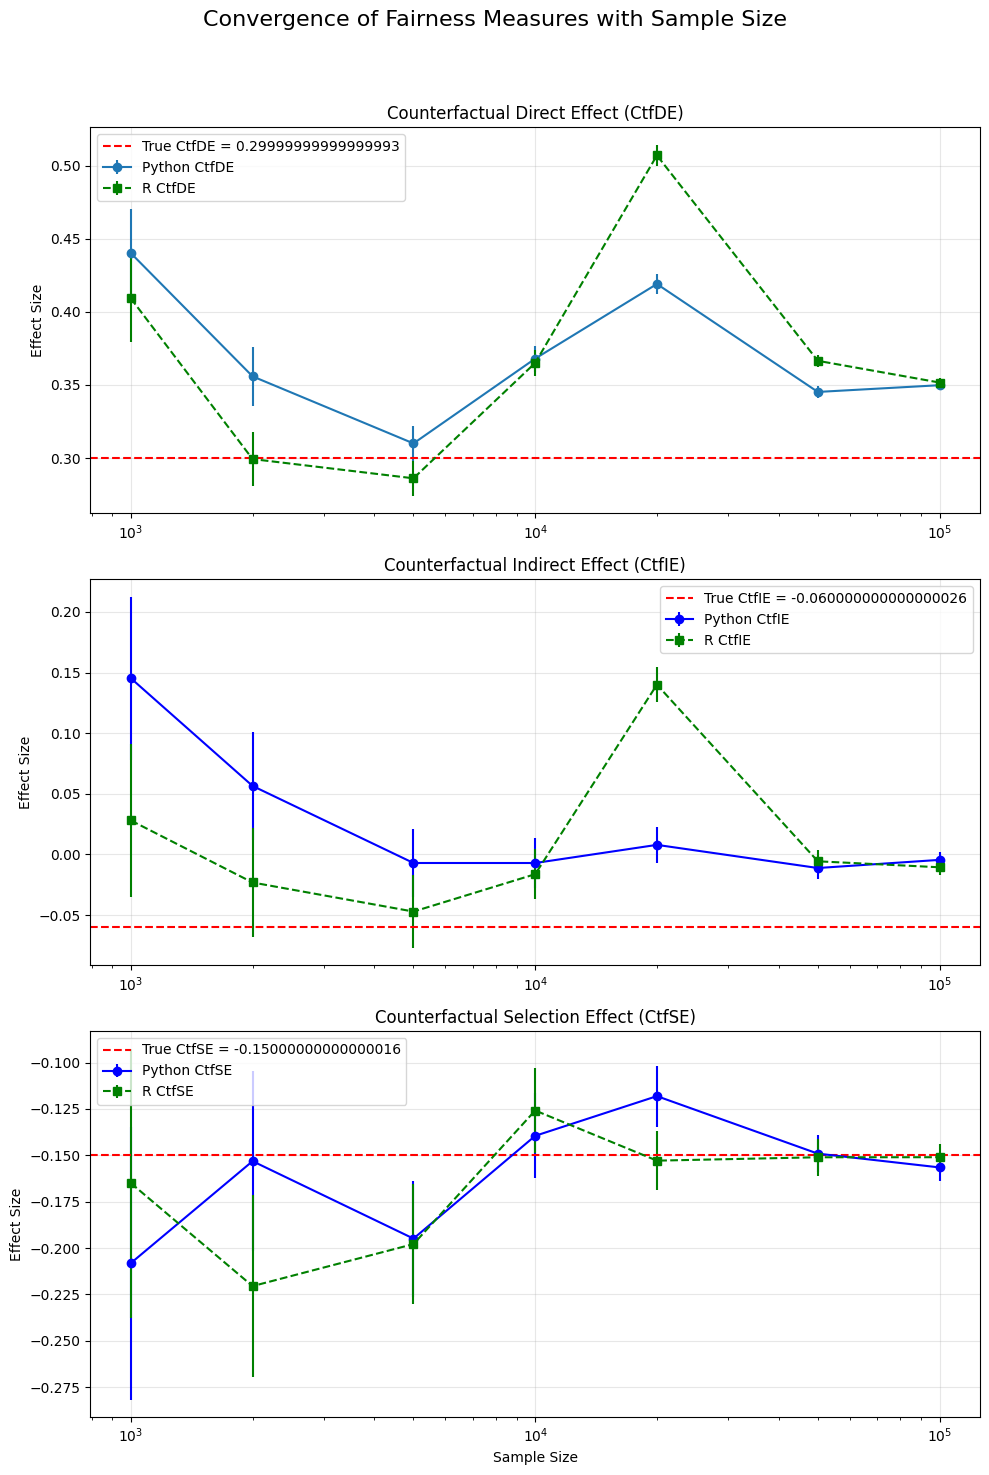

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle('Convergence of Fairness Measures with Sample Size', fontsize=16)

# Plot Counterfactual Direct Effect (CtfDE)
axs[0].errorbar(sample_seq, xde_py, yerr=xde_std_py, marker='o', linestyle='-', label='Python CtfDE')
axs[0].errorbar(sample_seq, xde_r, yerr=xde_std_r, marker='s', linestyle='--', label='R CtfDE', color='green')
axs[0].axhline(y=true_xde, color='r', linestyle='--', label=f'True CtfDE = {true_xde}')
axs[0].set_xscale('log')
axs[0].set_ylabel('Effect Size')
axs[0].set_title('Counterfactual Direct Effect (CtfDE)')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Plot Counterfactual Indirect Effect (CtfIE)
axs[1].errorbar(sample_seq, xie_py, yerr=xie_std_py, marker='o', linestyle='-', label='Python CtfIE', color='blue')
axs[1].errorbar(sample_seq, xie_r, yerr=xie_std_r, marker='s', linestyle='--', label='R CtfIE', color='green')
axs[1].axhline(y=true_xie, color='r', linestyle='--', label=f'True CtfIE = {true_xie}')
axs[1].set_xscale('log')
axs[1].set_ylabel('Effect Size')
axs[1].set_title('Counterfactual Indirect Effect (CtfIE)')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# Plot Counterfactual Selection Effect (CtfSE)
axs[2].errorbar(sample_seq, xse_py, yerr=xse_std_py, marker='o', linestyle='-', label='Python CtfSE', color='blue')
axs[2].errorbar(sample_seq, xse_r, yerr=xse_std_r, marker='s', linestyle='--', label='R CtfSE', color='green')
axs[2].axhline(y=true_xse, color='r', linestyle='--', label=f'True CtfSE = {true_xse}')
axs[2].set_xscale('log')
axs[2].set_xlabel('Sample Size')
axs[2].set_ylabel('Effect Size')
axs[2].set_title('Counterfactual Selection Effect (CtfSE)')
axs[2].legend()
axs[2].grid(True, alpha=0.3)



plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()


In [ ]:
# Benchmarking run time on a more realistic dataset

# Load census dataset
data = ro.r('''
    data("gov_census", package = "faircause")
    gov_census[seq_len(20000), ]  # Take first 20000 rows as in the vignette
''')

# Rename columns to match the vignette
data.columns = ['sex', 'age', 'race', 'hispanic_origin', 'citizenship', 'nativity',
                'marital', 'family_size', 'children', 'education_level', 'english_level',
                'salary', 'hours_worked', 'weeks_worked', 'occupation', 'industry',
                'economic_region']

X = "sex"
W = ["marital", "family_size", "children", "education_level",
    "english_level", "hours_worked", "weeks_worked", "occupation",
    "industry"]
Z = ["age", "race", "hispanic_origin", "citizenship", "nativity",
    "economic_region"]
Y = "salary"
x0 = "male"
x1 = "female"